# Subpopulation Discovery in Bladder Cancer Proteomics (Level 1)
This notebook identifies patterns in a bladder cancer proteomics dataset using unsupervised learning.

Course: Omics for Non-Biologists
Group name: Genomics

Group members:

- Ke Wang
- Carla Malo
- Marc Nanzer
- Jiayi Ma
- Choekyel Nyungmartsang

Expected input files

- ../data/proteomics.txt (required): protein abundance matrix
- ../data/metadata.csv (optional): clinical metadata
- ./src/ (required): helper functions used in this notebook

Dataset

- 140 patients
- 3,120 proteins
- Each value represents the measured abundance of one protein in one patient

Level 1 goal

- Build an unsupervised pipeline to group patients into clusters based on their protein profiles
- Justify the number of clusters using quantitative metrics and visual evidence

Planned approach

- Reduce dimensionality using PCA
- Apply KMeans clustering in the reduced space
- Evaluate clustering using elbow analysis, silhouette scores, and 2D visualizations (PCA and UMAP)

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2
from sklearn.metrics import pairwise_distances_argmin_min, silhouette_score
from sklearn.covariance import LedoitWolf

REQUIRED_FILES = ["proteomics.txt"]
for f in REQUIRED_FILES:
    if not os.path.exists(f):
        raise FileNotFoundError(f"Missing required input file: {f}")

if not os.path.isdir("./src"):
    raise FileNotFoundError(
        "Missing required folder './src'. "
        "Please include the 'src' directory containing 'bladder_proteomics' with the submission."
    )

from src.bladder_proteomics.utils import load_data, validate_data
from src.bladder_proteomics.preprocessing import log1p_transform, zscore_normalize, variance_filter, log2_transform, median_center_rows
from src.bladder_proteomics.dimensionality_reduction import apply_pca, pca_elbow, apply_umap, pc_names, compare_pca_diagnostics
from src.bladder_proteomics.clustering import kmeans_cluster
from src.bladder_proteomics.k_selection import elbow_method, silhouette_analysis, calculate_elbow_point, evaluate_k_selection_one, ari_stability_init, passes_min_cluster_size, pc_sensitivity_best_k
from src.bladder_proteomics.plotting import (get_cluster_colors, plot_2d_embedding,
                          plot_cluster_distributions, plot_cluster_sizes,
                          plot_clusters, plot_elbow, plot_heatmap,
                          plot_log10_raw_distribution,
                          plot_median_centering_diagnostics, plot_pca,
                          plot_pca_cumulative_variance,
                          plot_pca_scatter_with_outliers, plot_pca_variance,
                          plot_scree_and_cumulative, plot_silhouette_scores,
                          plot_umap, set_plot_style, plot_k_selection_grid,
                          overlay_flagged_outliers_on_clean_pca)
set_plot_style(dpi=120)

1. Data overview and preprocessing

Data orientation
- The proteomics file is loaded as a table with rows = patients and columns = proteins.

Preprocessing goals
- Make abundance values comparable across proteins and patients.
- Reduce the number of uninformative or redundant protein features before clustering.

Steps

1. Load the proteomics matrix and run basic validation checks (shape, missingness, duplicates, value range).
2. Remove protein features with identical expression profiles across patients (redundant features).
3. Visualize the raw dynamic range using a log10 histogram (diagnostic only).
4. Apply a log2 transform to compress the dynamic range (only valid for non-negative values).
    - If zeros exist, add a small pseudo-count; otherwise use log2(x) without an offset.
5. Normalize each patient by median centering on the log2 scale to reduce global sample-to-sample intensity shifts.
6. Remove (near) constant proteins and select the top 20 most variable proteins on the log2 scale.
7. Standardize selected proteins (z score per protein) so PCA and KMeans are driven by patterns rather than measurement scale.
8. Select variables for metadata and standardize
9. Combine proteomics and metadata
10. Fit PCA and compute Mahalanobis distance in PCA space to flag potential outlier patients for sensitivity analysis.

Notes on key choices

- Log2 transform: Raw proteomics values span a very large range. Log2 compresses extremes and is common in proteomics (fold changes become interpretable on a base-2 scale).
- Median centering (sample-level): Proteomics samples can differ in overall intensity due to technical effects (loading amount, instrument drift). Median centering reduces global shifts so clustering focuses more on relative protein patterns. This may also remove real biological “global intensity” effects, so we treat it as a practical normalization choice and report sensitivity checks.
- Feature selection (top 20% by variance): We reduce dimensionality by keeping proteins that vary most across patients on the log2 scale. This is mainly for denoising and dimensionality reduction.

In [3]:
# Load + validate
df = load_data("proteomics.txt", transpose=True, index_col=0, sep="\t")
validate_data(df) # each patient is now a column
print(f"Raw value range: min={df.min().min():.4g}, max={df.max().max():.4g}")

Removed proteins with identical profiles: 9
Data shape (samples × features): (140, 3112)
Missing values: 0
Duplicate rows: 0 | Duplicate columns: 0
Raw value range: min=1.163, max=7.19e+20


The raw protein abundances span a very large dynamic range (up to ~7e20).
To make patterns comparable across patients and reduce the impact of extreme values, we transform the data to a log scale.
We use log2 because it is commonly used in proteomics (fold changes become interpretable on a base 2 scale).

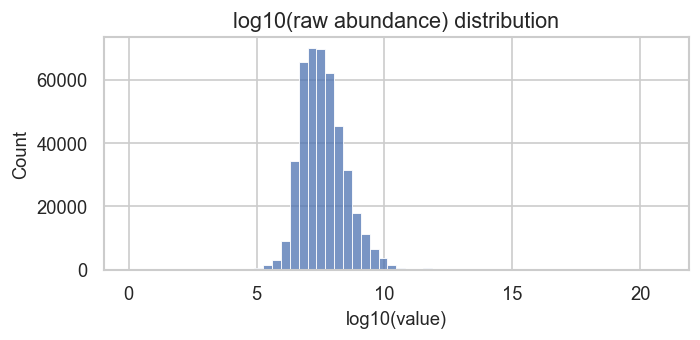

In [4]:
# log10(raw) distribution (interpretable dynamic range)
plot_log10_raw_distribution(df)
plt.tight_layout()
plt.show()

Figure: Histogram of log10-transformed raw abundance values pooled across all proteins and patients.
This is a quick diagnostic to show the extreme dynamic range of the raw measurements and motivate log-scale preprocessing.
All downstream preprocessing uses a log2 transformation for interpretability.

In [5]:
# log2 transform
df_log2, log_info = log2_transform(df, pseudocount="auto")
print("log2 transform info:", log_info)

log2 transform info: {'has_zero': 0.0, 'pseudocount_used': 0.0}


# Sample-level normalization: median centering (log2 scale)
To reduce global sample-to-sample intensity shifts, we subtract each patient’s median log2 abundance from all proteins in that patient.

We show:

- the distribution of per-patient median log2 intensities before centering
and that these medians are aligned around zero after centering (by construction)
- A more informative visualization (density curves across several patients) can be seen in the Supplement section S1A.

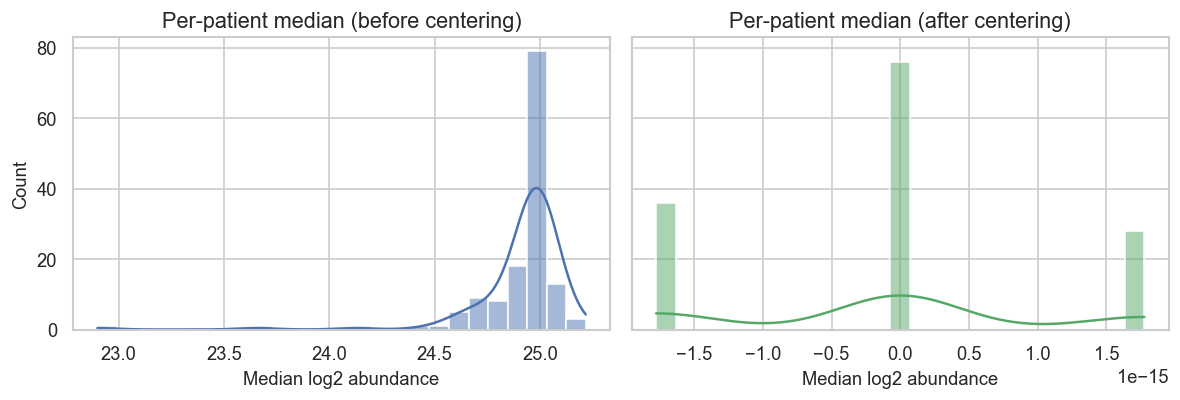

In [6]:
# median centering + diagnostic plots
df_log2_before = df_log2.copy()
df_log2 = median_center_rows(df_log2)
fig1 = plot_median_centering_diagnostics(df_log2_before, df_log2)
plt.show()

Figure: Diagnostic plots for median centering on the log2 scale.
Left: per patient median log2 intensity before centering. Right: after centering the median is aligned around zero by construction.

The density curves in the supplementary section show that centering reduces global intensity shifts across patients while keeping the overall shape of protein distributions similar.

We select the top 20 percent most variable proteins before z score scaling, because z scoring would force all proteins to have similar variance and would remove the basis for variance based feature selection.

In [7]:
# Feature selection: top 20 by variance on log scale
top_fraction = 0.0065
variances = df_log2.var(axis=0).sort_values(ascending=False) # variance per protein and sort form highest to lowest variance

# in total we have 3112 proteins and we want to select only the top 20

k = max(2, int(len(variances) * top_fraction)) # decide how many proteins to keep (20)
top_features = variances.index[:k]
df_sel_log = df_log2.loc[:, top_features].copy() # keep all rows (patients) but keep only top proteins (columns)
print(f"After feature selection (top {int(top_fraction*100)}% by variance): {df_sel_log.shape}")

After feature selection (top 0% by variance): (140, 20)


In [8]:
# Z-score per protein for PCA/KMeans
df_scaled = zscore_normalize(df_sel_log, axis=0)

Now that we have scaled the proteomics data, we will now select and scale the metadata so that we can then combine them

In [13]:
metadata_df = pd.read_csv("metadata.csv")
metadata_df = metadata_df.set_index("Patient_ID")

Variables we consider, because we think that they are relevant to determine relevant patient subpopulations:
* age: patient intrinsic factor influencing tumor progression
* tumor_size: direct measure of severity
* metastasis: indicator of disease spread
* family_history_of_cancer: genetic risk factor
* smoking_history: known cancer risk factor
* histological_grade: reflects aggressiveness

In [10]:
meta_cols = [
    "Age",
    "Tumor_Size_mm",
    "Metastasis",
    "Family_History_of_Cancer",
    "Smoking_History",
    "Histological_Grade"
]

In [14]:
metadata_df_used = metadata_df[meta_cols].copy()

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

metadata_df_used["Age_scaled"] = scaler.fit_transform(metadata_df_used[["Age"]])
metadata_df_used["Tumor_Size_mm_scaled"] = scaler.fit_transform(metadata_df_used[["Tumor_Size_mm"]])
metadata_df_used["Metastasis_encoded"] = metadata_df_used["Metastasis"].map({"Yes": 1, "No": 0})
metadata_df_used["Family_History_encoded"] = metadata_df_used["Family_History_of_Cancer"].map({"Yes": 1, "No": 0})
metadata_df_used["Smoking_encoded"] = metadata_df_used["Smoking_History"].map({"Yes": 1, "No": 0})
grade_map = {"Low": 1, "Intermediate": 2, "High": 3}
metadata_df_used["Grade_encoded"] = metadata_df_used["Histological_Grade"].map(grade_map)

In [16]:
metadata_df_used_scaled = metadata_df_used.copy()
metadata_df_used_scaled = metadata_df_used_scaled.drop(columns=[
        "Age",
        "Tumor_Size_mm",
        "Metastasis",
        "Family_History_of_Cancer",
        "Smoking_History",
        "Histological_Grade"
    ]
)
metadata_df_used_scaled.head()
metadata_df_used_scaled.shape

(140, 6)

Now we can combine the metadata and proteomics data

In [17]:
combined_df_proteomics_metadata = pd.concat([df_scaled, metadata_df_used_scaled], axis = 1)
combined_df_proteomics_metadata.head()
combined_df_proteomics_metadata.shape

(140, 26)

Now we can make a pca plot of the combined data

In [18]:
pca_var_target = 0.8 # get enough pcs to explain ~80% of the total variance
pca_df, pca_model = apply_pca(combined_df_proteomics_metadata, n_components=pca_var_target, return_model=True)
pca_df = pc_names(pca_df)

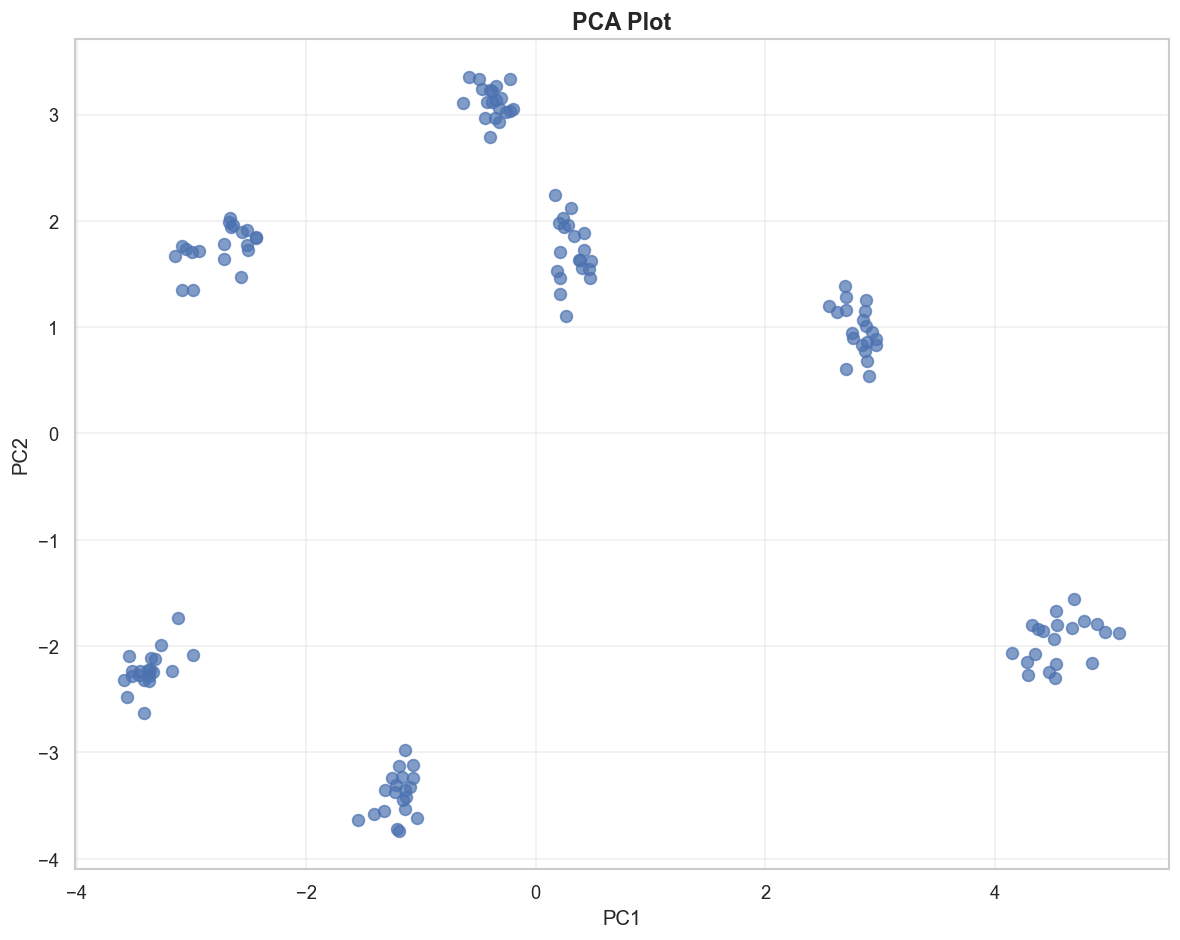

In [19]:
# PCA scatter
pca2 = pca_df.iloc[:, :2].copy()  # already PC1/PC2 if pc_names applied
plot_pca(pca2)
plt.tight_layout()
plt.show()

We wanted our principal components to explain ~80% of the variance in the data and since this was achieved with 4 principal components, it indicates a compact low-dimensional structure. Therefore, clustering was performed in this PCA space.

We cluster patients using KMeans applied to a PCA embedding of the preprocessed protein matrix.

- Why KMeans: KMeans is a widely used baseline for clustering continuous data. It is computationally simple and provides an interpretable partition of patients into groups based on Euclidean distances in the chosen feature space. We treat KMeans clusters as candidate patient subgroups that require validation (robustness checks and downstream interpretation).
- Why PCA before KMeans: High-dimensional omics data can make Euclidean distances less informative. PCA provides a lower-dimensional representation and produces uncorrelated principal components that capture the main variance directions used for clustering.
- Distance metric: After per-protein z-score standardization and PCA reduction, Euclidean distance in PCA space is a reasonable choice for KMeans because all dimensions are on a comparable scale.

Visual inspection of the PCA projection suggests the presence of multiple groups. We now want to determine the best number of clusters with the "elbow" and the silhouette.

We evaluate candidate numbers of clusters K using complementary diagnostics:

- Elbow (inertia / WCSS): shows diminishing returns in within-cluster dispersion as K increases. This is a rough diagnostic and often decreases smoothly.
- Silhouette score: measures how separated clusters are in the chosen embedding. However, silhouette can be artificially high when a few extreme samples form very small clusters.

To reduce the risk of selecting K based on artifacts, we add two robustness checks (Supplement section S4):

- Cluster-size sanity check: we flag solutions dominated by very small clusters, because these often reflect outliers rather than stable cohort subpopulations.
- Stability (ARI across KMeans initializations): we compute KMeans with a single random seed and measure agreement (ARI). This measures sensitivity to initialization, not sampling variability.

We run K selection on the combined dataset.

Decision rule: We prefer the smallest K that (i) has reasonable separation, (ii) does not rely on tiny clusters, and (iii) is stable across reasonable PCA dimensions and the outlier sensitivity check.

  File "C:\Users\marca\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\marca\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\marca\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\marca\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


[Combined]  elbow_k=5 | best_k_sil=7 (score=0.859)


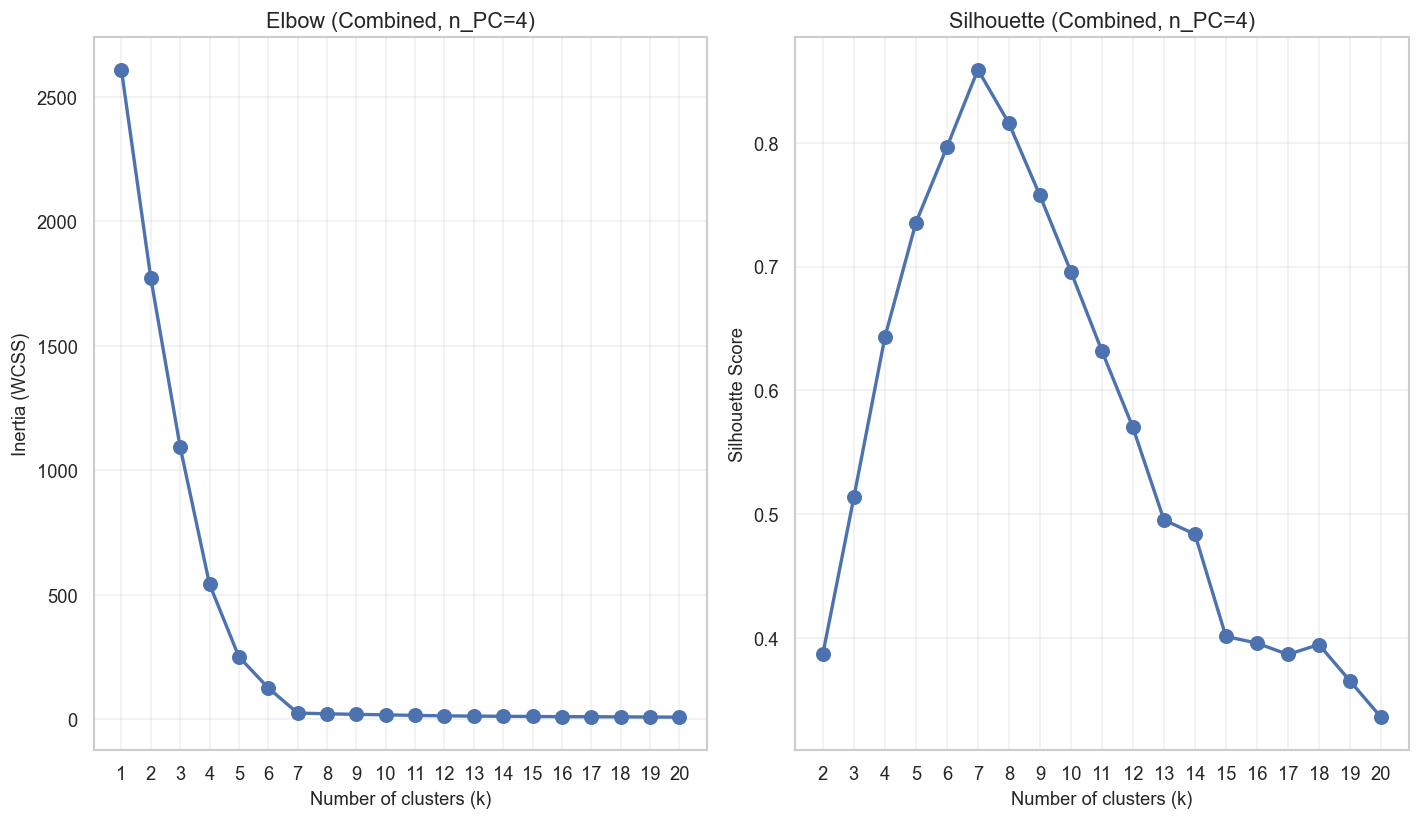

In [20]:
# K selection for PC = 4
k_max = 20
n_pc = 4

X_pca_combined = pca_df.iloc[:, :n_pc].copy()

res_combined = evaluate_k_selection_one(X_pca_combined, k_max=k_max)

print(f"[Combined]  elbow_k={res_combined['elbow_k']} | best_k_sil={res_combined['best_k_sil']} (score={res_combined['best_sil']:.3f})")

def plot_k_selection(combined):
    fig, axes = plt.subplots(1, 2, figsize=(12,7))
    plot_elbow(combined["inertia"], ax=axes[0], title=f"Elbow (Combined, n_PC=4)")
    plot_silhouette_scores(combined["silhouette"], ax=axes[1], title=f"Silhouette (Combined, n_PC=4)")
    fig.tight_layout()
    return fig, axes

plot_k_selection(res_combined)
plt.tight_layout()
plt.show()

Figure: Elbow (inertia) and silhouette curves for KMeans clustering using 4 PCs.
The elbow is a rough diagnostic for diminishing returns, while silhouette reflects separation but can be inflated by tiny clusters.

Result:
Looking back at the pca plot from before, one can already guess that the best number of cluster would be 7. As we can see the silhouette score confirms this since the highest score is achieved for 7 clusters. Also, the sanity check shows that our clusters are of reasonable size, since they all have the same size of 20.

In [21]:
# Sanity check: cluster sizes for best silhouette solutions
labels_combined_best = pd.Series(
    kmeans_cluster(X_pca_combined, n_clusters=res_combined["best_k_sil"], align_labels=True),
    index=X_pca_combined.index
)
print("Combined best-k cluster sizes:")
print(labels_combined_best.value_counts().sort_index())

Combined best-k cluster sizes:
0    20
1    20
2    20
3    20
4    20
5    20
6    20
Name: count, dtype: int64


Lastly we compute the gap statistic to make sure that the clustering the data into 7 groups is not random chance.

Gap statistic compares how much better does clustering fit the real data compared to random data.

In [22]:
import numpy as np
from sklearn.cluster import KMeans

# X: data, k_max: max number of cluster, B: number of reference datasets, n_init: how many times KMeans restarts with different initial cnetroids
def gap_statistic(X, k_max=20, B=50, random_state=42, n_init=10):
    rng = np.random.default_rng(random_state)

    # generate points randomly in range of our data
    mins = X.min(axis=0) # get min of every pc
    maxs = X.max(axis=0) # get max of every pc

    wk = np.zeros(k_max)
    gap = np.zeros(k_max)
    se = np.zeros(k_max)

    # compute gap for each candidate of cluster
    for k in range(1, k_max + 1):
        km = KMeans(n_clusters=k, n_init=n_init, random_state=random_state)
        km.fit(X)
        wk[k-1] = km.inertia_

        ref_wk = np.zeros(B)
        for b in range(B): # generate B reference datasets and cluster them
            X_ref = rng.uniform(mins, maxs, size=X.shape) # create random dataset
            km_ref = KMeans(n_clusters=k, n_init=n_init, random_state=random_state) # cluster random dataset
            km_ref.fit(X_ref)
            ref_wk[b] = km_ref.inertia_

        gap[k-1] = ref_wk.mean() - (wk[k-1]) # compute gap
        se[k-1] = ref_wk.std(ddof=1) / np.sqrt(B) # compute standard error

    # smallest k with Gap(k) >= Gap(k+1) - se(k+1)
    optimal_k = k_max
    for k in range(1, k_max):
        if gap[k-1] >= gap[k] - se[k]:
            optimal_k = k
            break

    return gap, se, wk, optimal_k

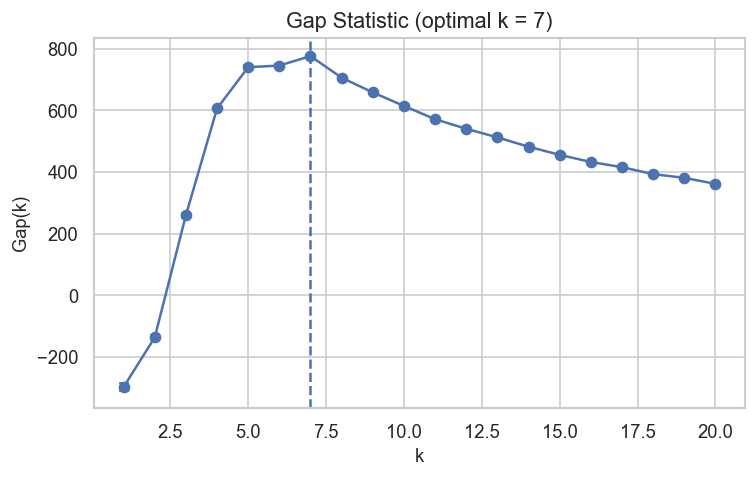

In [23]:
import matplotlib.pyplot as plt

gap, se, wk, k_opt = gap_statistic(X_pca_combined, k_max=20, B=50, random_state=0)

ks = np.arange(1, len(gap)+1)
plt.figure(figsize=(7,4))
plt.errorbar(ks, gap, yerr=se, marker='o', capsize=3)
plt.axvline(k_opt, linestyle='--')
plt.xlabel("k")
plt.ylabel("Gap(k)")
plt.title(f"Gap Statistic (optimal k = {k_opt})")
plt.grid(True)
plt.show()

Now that we have shown that k = 7 is the best choice, we now want to see how the metadata is separated by the clusters.

In [24]:
km_final = KMeans(n_clusters=7, random_state=42, n_init=10)
km_final.fit(X_pca_combined)
final_labels = pd.Series(km_final.labels_, index=X_pca_combined.index, name="Cluster")
cluster_counts = final_labels.value_counts().sort_index()
cluster_counts

Cluster
0    20
1    20
2    20
3    20
4    20
5    20
6    20
Name: count, dtype: int64

In [25]:
metadata_df_with_clusters = metadata_df_used.copy()
metadata_df_with_clusters["Cluster"] = final_labels
cluster_summary_numeric = (metadata_df_with_clusters.groupby("Cluster")[["Age", "Tumor_Size_mm"]].agg(["mean"]))
cluster_summary_numeric

,Age,Tumor_Size_mm
,mean,mean
Cluster,,
0,63.90,47.35
1,68.25,76.60
2,61.55,34.35
3,64.80,123.70
4,63.05,50.70
5,63.45,44.15
6,62.25,54.40


In [26]:
metadata_df_with_clusters_scaled = metadata_df_used_scaled.copy()
metadata_df_with_clusters_scaled["Cluster"] = final_labels
cluster_summary_encoded = (metadata_df_with_clusters_scaled.groupby("Cluster")[["Metastasis_encoded", "Family_History_encoded", "Smoking_encoded", "Grade_encoded"]].mean())
cluster_summary_encoded

,Metastasis_encoded,Family_History_encoded,Smoking_encoded,Grade_encoded
Cluster,,,,
0,0.00,0.15,0.70,2.50
1,0.20,0.35,0.65,2.55
2,0.00,0.20,0.50,1.70
3,0.20,0.05,0.60,2.30
4,0.55,0.15,0.75,2.65
5,0.00,0.10,0.60,1.80
6,0.75,0.25,0.60,2.50


Cluster-wise summaries show large differences in tumor size and metastatic status across clusters, while age and smoking status vary only weakly. Family history and histological grade show some but less clear differences between clusters.
This pattern suggests that the identified clusters reflect mostly differences in tumor size and disease spread, rather than background risk factors such as age, smoking, or family history.

Now we create the pca plot with the clusters

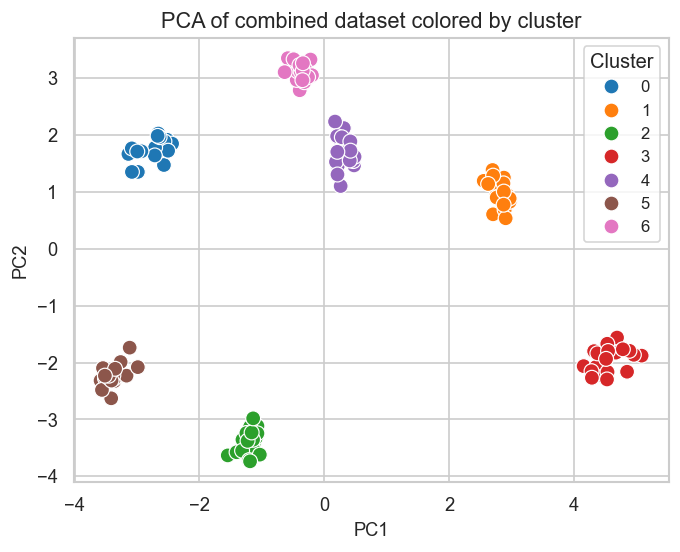

In [27]:
pca_plot_df = pca_df.iloc[:, :2].copy()
pca_plot_df["Cluster"] = final_labels

sns.scatterplot(
    data=pca_plot_df,
    x="PC1",
    y="PC2",
    hue="Cluster",
    palette="tab10",
    s=80
)
plt.title("PCA of combined dataset colored by cluster")
plt.show()

Create boxplots for tumor_size, metastasis and age:

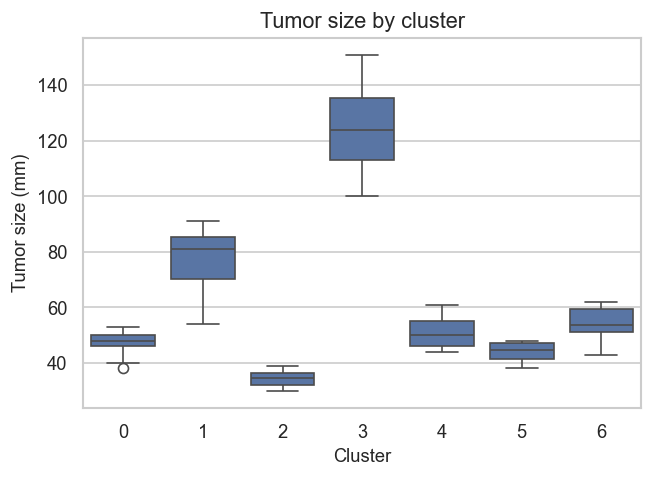

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.boxplot(
    data=metadata_df_with_clusters,
    x="Cluster",
    y="Tumor_Size_mm"
)
plt.title("Tumor size by cluster")
plt.xlabel("Cluster")
plt.ylabel("Tumor size (mm)")
plt.show()

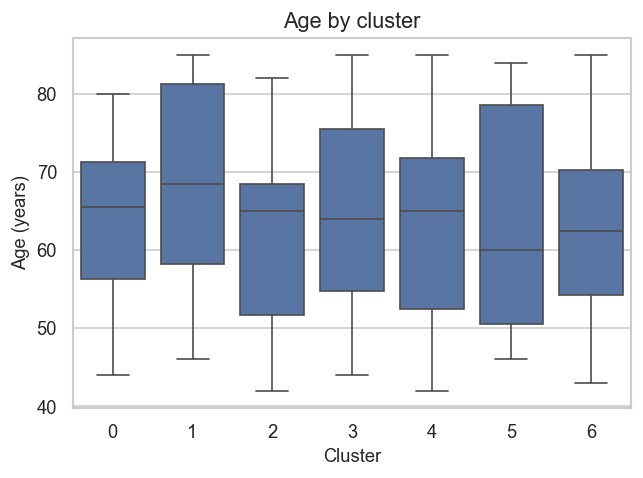

In [29]:
plt.figure(figsize=(6,4))
sns.boxplot(
    data=metadata_df_with_clusters,
    x="Cluster",
    y="Age"
)
plt.title("Age by cluster")
plt.xlabel("Cluster")
plt.ylabel("Age (years)")
plt.show()

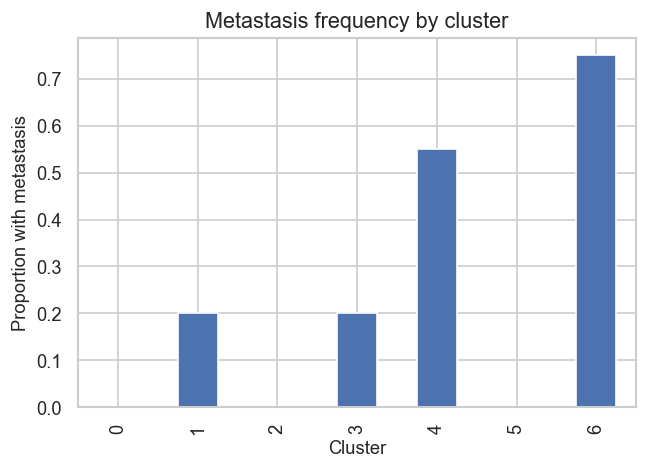

In [30]:
metastasis_rate = (
    metadata_df_with_clusters
    .groupby("Cluster")["Metastasis_encoded"]
    .mean()
)

plt.figure(figsize=(6,4))
metastasis_rate.plot(kind="bar")
plt.ylabel("Proportion with metastasis")
plt.xlabel("Cluster")
plt.title("Metastasis frequency by cluster")
plt.show()

Now we compare PCA dimensionality with outliers included vs excluded to see how much extreme samples influence the variance structure. After pca, each principal component (pc) explains some fraction of the total variance in the data, so we check how many pcs do we need tp explain 80% of the total variance